In [1]:
import sys
sys.path.append("../code")
import pandas as pd
import random
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import blotto_utils as bu
from agent import Agent
import agent_utils as au

In [3]:
import scipy.optimize

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# 538 Data

In [6]:
weights = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

data_dir = '/Users/Alex/Documents/Alex/Yale/Fall 2019/CPSC_490/blotto/data/'

fivethirtyeight_data_dir = data_dir + 'fivethirtyeight/'

sorted(glob(fivethirtyeight_data_dir + '*'))

temp_df = pd.read_csv(glob(fivethirtyeight_data_dir + '*')[0])

new_column_names = list(map((lambda x : '_'.join(x.split(' ')).lower()), list(temp_df.columns)))
new_column_names[-1] = 'reason'

temp_df.rename(dict(zip(list(temp_df.columns), new_column_names)), axis=1, inplace=True)

temp_df['total_troops'] = temp_df['castle_1'] + \
                          temp_df['castle_2'] + \
                          temp_df['castle_3'] + \
                          temp_df['castle_4'] + \
                          temp_df['castle_5'] + \
                          temp_df['castle_6'] + \
                          temp_df['castle_7'] + \
                          temp_df['castle_8'] + \
                          temp_df['castle_9'] + \
                          temp_df['castle_10']

full_strats_df = temp_df[temp_df.total_troops == 100].copy()

full_strats_list = full_strats_df.to_dict('records')

simp_strats_list = [[int(x[1]) for x in list(y.items())[:10]] for y in full_strats_list]

## Divide into two players

In [7]:
random.seed(0)

In [8]:
a_strat_init = random.sample(simp_strats_list, 100)
b_strat_init = random.sample(simp_strats_list, 100)

In [9]:
len(a_strat_init), len(b_strat_init)

(100, 100)

# Agent

In [101]:
random.seed(0)

In [102]:
temp_noise = bu.generate_noise_arrays(1)

In [103]:
def evolve(a_strats, b_strats, generations, noise):
    for _ in range(generations):
        a_results, b_results = bu.eval_strats(a_strats, b_strats, weights)

        a_fittest = sorted(a_results, key=(lambda x: (x[1], -(x[0][-1]))), reverse=True)
        b_fittest = sorted(b_results, key=(lambda x: (x[1], -(x[0][-1]))), reverse=True)

        a_next_gen = []
        b_next_gen = []
        for i in range(14):
            for j in range(i+1, 15):
                a_next_gen.append(bu.mutate_noise(bu.make_integer(bu.cross([a_fittest[i][0], a_fittest[j][0]]), seed=(i+j+i*j)), temp_noise, seed=(i+j)))
                b_next_gen.append(bu.mutate_noise(bu.make_integer(bu.cross([b_fittest[i][0], b_fittest[j][0]]), seed=(i+j+i*j)), temp_noise, seed=(i+j)))

        a_strats = a_next_gen
        b_strats = b_next_gen
        
    return a_fittest, b_fittest, a_strats, b_strats

In [104]:
a_strat_init = random.sample(simp_strats_list, 100)
b_strat_init = random.sample(simp_strats_list, 100)

a_strats = a_strat_init
b_strats = b_strat_init

In [105]:
temp_a_strats, temp_b_strats = a_strats, b_strats

In [106]:
best_a, best_b = [], []

In [222]:
for i in range(200):
#     print(i)
    temp_a_fittest, temp_b_fittest, temp_a_strats, temp_b_strats = evolve(temp_a_strats, temp_b_strats, 1, temp_noise)
    best_a.append(temp_a_fittest[0][0])
    best_b.append(temp_b_fittest[0][0])
#     print('\n'.join(map(str,temp_a_fittest[:5])))

In [223]:
len(best_a), len(best_b)

(600, 600)

In [109]:
agent_evol_a = Agent(best_a)
agent_evol_b = Agent(best_b)

# Linear Programming Testing (Nash)

input are two sets of strategies -> probabilities associated with each for Nash

## linear programming evolutionary strategies

In [166]:
probs_evol_a, probs_evol_b = bu.blotto_nash(best_a, best_b)

In [167]:
sum(probs_evol_a), sum(probs_evol_b)

(1.0000020000000003, 0.9999979999999998)

In [168]:
probs_evol_a_norm = bu.normalize_probabilities(probs_evol_a)
probs_evol_b_norm = bu.normalize_probabilities(probs_evol_b)

In [169]:
sum(probs_evol_a_norm), sum(probs_evol_b_norm)

(1.0, 0.9999999999999999)

In [170]:
agent_evol_lin_a = Agent(best_a, list(probs_evol_a_norm))
agent_evol_lin_b = Agent(best_b, list(probs_evol_b_norm))

In [171]:
au.play_game(agent_evol_lin_a, agent_evol_lin_b, weights, weights, trials=10000) / 10000

0.2638

In [172]:
au.play_game(agent_evol_lin_b, agent_evol_lin_a, weights, weights, trials=10000) / 10000

0.7717

### test based on how many of "best" we include

In [218]:
a_results = []
b_results = []

In [224]:
for index in range(len(a_results) + 1, len(best_a)//5):
    num = 5*index
    temp_probs_evol_a, temp_probs_evol_b = bu.blotto_nash(best_a[:num], best_b[:num])
    temp_probs_evol_a_norm = bu.normalize_probabilities(temp_probs_evol_a)
    temp_probs_evol_b_norm = bu.normalize_probabilities(temp_probs_evol_b)
    temp_agent_evol_lin_a = Agent(best_a[:num], list(temp_probs_evol_a_norm))
    temp_agent_evol_lin_b = Agent(best_b[:num], list(temp_probs_evol_b_norm))
    
    a_results.append(0.5 + au.play_game(temp_agent_evol_lin_a, simp_strats_list, weights, weights, trials=len(simp_strats_list)) / (2*len(simp_strats_list)))
    b_results.append(0.5 + au.play_game(temp_agent_evol_lin_b, simp_strats_list, weights, weights, trials=len(simp_strats_list)) / (2*len(simp_strats_list)))    

/Users/Alex/anaconda3/lib/python3.6/site-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=3.0728e-34): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


In [227]:
len(a_results)

119

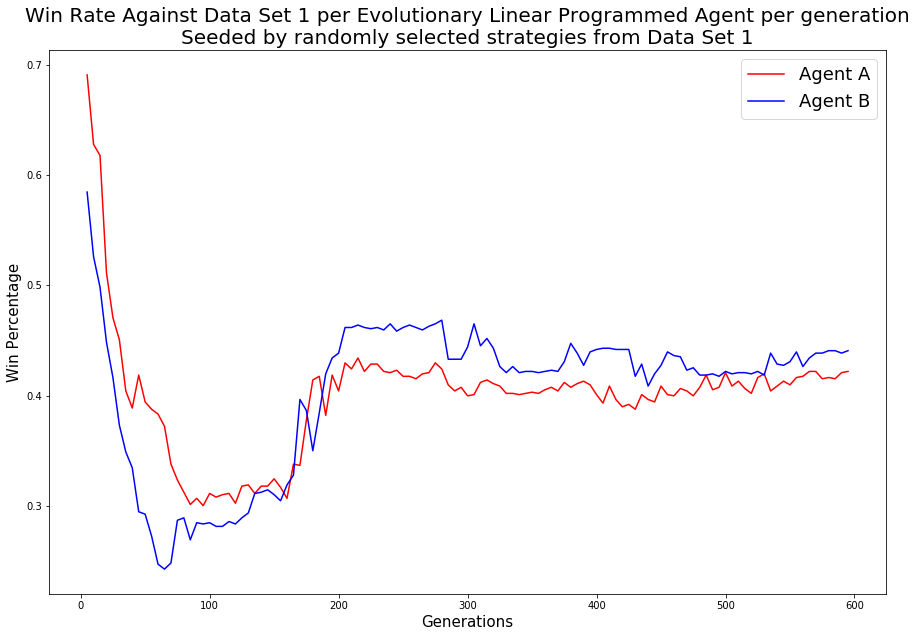

In [237]:
plt.figure(figsize=(15, 10))
plt.plot([5*x for x in list(range(1, len(best_a)//5))], a_results, label='Agent A', color='r')
plt.plot([5*x for x in list(range(1, len(best_a)//5))], b_results, label='Agent B', color='b')
plt.title("Win Rate Against Data Set 1 per Evolutionary Linear Programmed Agent per generation\nSeeded by randomly selected strategies from Data Set 1", fontsize=20)
plt.xlabel("Generations", fontsize=15)
plt.ylabel("Win Percentage", fontsize=15)
plt.legend(prop={'size':18})
# plt.show()
plt.savefig("../figures/data-set-1-win-rate-evol-lin.jpg")

## testing

In [173]:
probs_a, probs_b = bu.blotto_nash(a_strat_init, b_strat_init)

In [174]:
sum(probs_a), sum(probs_b)

(1.0000000000000002, 1.000001)

In [175]:
probs_a_norm = bu.normalize_probabilities(probs_a)
probs_b_norm = bu.normalize_probabilities(probs_b)

In [176]:
print(sum(probs_a_norm))
print(sum(probs_b_norm))

1.0000000000000002
0.9999999999999999


In [177]:
agent_a = Agent(a_strat_init, list(probs_a_norm))
agent_b = Agent(b_strat_init, list(probs_b_norm))

In [178]:
au.play_game(agent_a, agent_b, weights, weights, trials=1000) / 1000 # b is the better agent on average

0.549

In [179]:
au.play_game(agent_a, simp_strats_list, weights, weights, trials=len(simp_strats_list)) / len(simp_strats_list)

0.6168327796234773

In [180]:
au.play_game(agent_b, simp_strats_list, weights, weights, trials=len(simp_strats_list)) / len(simp_strats_list)

0.6157253599114064

# Agent Tester

In [181]:
au.play_game(agent_b, agent_evol_b, weights, weights, trials=10000) / 10000

0.6419

In [182]:
au.play_game(agent_b, agent_evol_a, weights, weights, trials=10000) / 10000

0.5628

In [183]:
au.play_game(agent_a, agent_evol_a, weights, weights, trials=10000) / 10000

0.6456

In [184]:
au.play_game(agent_a, agent_evol_b, weights, weights, trials=10000) / 10000

0.6282

In [185]:
au.play_game(agent_evol_b, agent_a, weights, weights, trials=10000) / 10000

0.3546

In [186]:
au.play_game(agent_evol_lin_b, simp_strats_list, weights, weights, trials=len(simp_strats_list)) / len(simp_strats_list)

0.5116279069767442

In [187]:
au.play_game(agent_evol_lin_a, simp_strats_list, weights, weights, trials=len(simp_strats_list)) / len(simp_strats_list)

0.3964562569213732

In [188]:
au.play_game(agent_evol_lin_a, agent_b, weights, weights, trials=10000) / 10000

0.3644

In [189]:
au.play_game(agent_evol_lin_a, agent_a, weights, weights, trials=10000) / 10000

0.5077

In [190]:
au.play_game(agent_evol_lin_b, agent_a, weights, weights, trials=10000) / 10000

0.5088

In [191]:
au.play_game(agent_evol_lin_b, agent_b, weights, weights, trials=10000) / 10000

0.8251